In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /home/jupyter/+data/daily-min-temperatures.csv

--2021-06-20 22:54:26--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/home/jupyter/+data/daily-min-temperatures.csv’

/home/jupyter/+data 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2021-06-20 22:54:26 (5.20 MB/s) - ‘/home/jupyter/+data/daily-min-temperatures.csv’ saved [67921/67921]



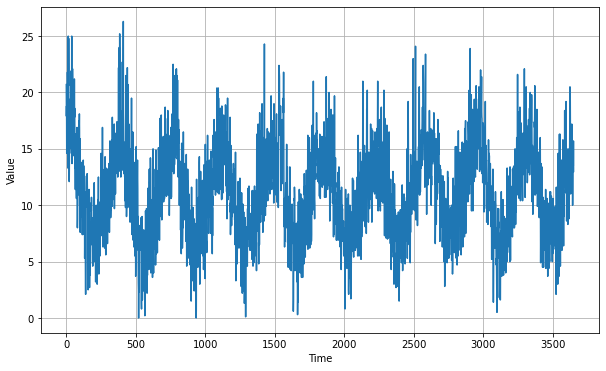

In [4]:
import csv
time_step = []
temps = []

with open("/home/jupyter/+data/daily-min-temperatures.csv") as file:
    file.readline()
    for i, line in enumerate(file, 1):
        date, temp = line.replace("\n", "").split(",")
        temps.append(float(temp))
        time_step.append(i)
series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [79]:
def windowed_dataset(series, window_size=30, batch_size=32, shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size+1))
    dataset = dataset.map(lambda w: (w[:-1], w[-1:]))
    dataset = dataset.shuffle(shuffle_buffer).batch(batch_size).prefetch(1)
    return dataset

In [83]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(32).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 50
batch_size = 100
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# print(train_set)
# print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(16, 5, activation="relu"),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(optimizer = optimizer,
              loss = tf.keras.losses.Huber(),
              metrics = ["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

(1e-08, 0.1, 0.0, 10.0)

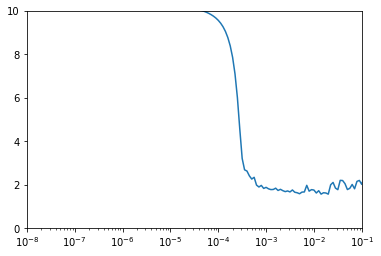

In [53]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 10])

In [67]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, 60, 100, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(16, 5, activation="relu"),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=5e-3, momentum=0.9)
model.compile(optimizer = optimizer,
              loss = tf.keras.losses.Huber(),
              metrics = ["mae"])
history = model.fit(train_set, epochs=100)

Epoch 1/100
25/25 [==============================] - 3s 11ms/step - loss: 8.8839 - mae: 9.3812
Epoch 2/100
25/25 [==============================] - 0s 11ms/step - loss: 2.9934 - mae: 3.4614
Epoch 3/100
25/25 [==============================] - 0s 11ms/step - loss: 2.4746 - mae: 2.9375
Epoch 4/100
25/25 [==============================] - 0s 10ms/step - loss: 2.2175 - mae: 2.6751
Epoch 5/100
25/25 [==============================] - 0s 10ms/step - loss: 1.8000 - mae: 2.2499
Epoch 6/100
25/25 [==============================] - 0s 10ms/step - loss: 1.7855 - mae: 2.2373
Epoch 7/100
25/25 [==============================] - 0s 11ms/step - loss: 1.7530 - mae: 2.2033
Epoch 8/100
25/25 [==============================] - 0s 11ms/step - loss: 1.7906 - mae: 2.2422
Epoch 9/100
25/25 [==============================] - 0s 11ms/step - loss: 1.6790 - mae: 2.1248
Epoch 10/100
25/25 [==============================] - 0s 12ms/step - loss: 1.6356 - mae: 2.0818
Epoch 11/100
25/25 [=============================

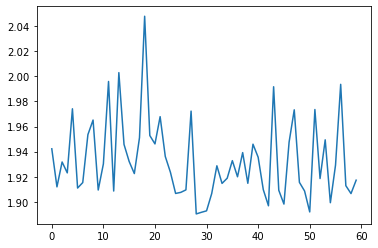

In [68]:
plt.plot(history.history["mae"][40:])

In [87]:
window_size

50

In [85]:
rnn_forecast = model_forecast(model, series, window_size)
# rnn_forecast = rnn_forecast[split_time - window_size:-1, -1]
rnn_forecast.shape

(3601, 1)

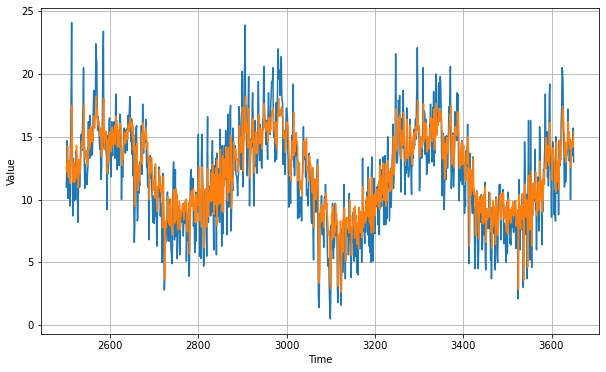

In [77]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [78]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.8180426